我们在7.5节（AdaGrad算法）中提到，因为调整学习率时分母上的变量$\boldsymbol{s}_t$一直在累加按元素平方的小批量随机梯度，所以目标函数自变量每个元素的学习率在迭代过程中一直在降低（或不变）。因此，当学习率在迭代早期降得较快且当前解依然不佳时，AdaGrad算法在迭代后期由于学习率过小，可能较难找到一个有用的解。为了解决这一问题，RMSProp算法对AdaGrad算法做了一点小小的修改。该算法源自Coursera上的一门课程，即“机器学习的神经网络” [1]。

## 7.6.1 算法

我们在7.4节（动量法）里介绍过指数加权移动平均。不同于AdaGrad算法里状态变量$\boldsymbol{s}_t$是截至时间步$t$所有小批量随机梯度$\boldsymbol{g}_t$按元素平方和，**RMSProp算法将这些梯度按元素平方做指数加权移动平均**。具体来说，给定超参数$0 \leq \gamma < 1$，RMSProp算法在时间步$t>0$计算

$$\boldsymbol{s}_t \leftarrow \gamma \boldsymbol{s}_{t-1} + (1 - \gamma) \boldsymbol{g}_t \odot \boldsymbol{g}_t. $$

和AdaGrad算法一样，RMSProp算法将目标函数自变量中每个元素的学习率通过按元素运算重新调整，然后更新自变量

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \frac{\eta}{\sqrt{\boldsymbol{s}_t + \epsilon}} \odot \boldsymbol{g}_t, $$

其中$\eta$是学习率，$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-6}$。因为RMSProp算法的状态变量$\boldsymbol{s}_t$是对平方项$\boldsymbol{g}_t \odot \boldsymbol{g}_t$的指数加权移动平均，所以可以看作是最近$1/(1-\gamma)$个时间步的小批量随机梯度平方项的加权平均。**如此一来，自变量每个元素的学习率在迭代过程中就不再一直降低（或不变）**。

**注：这样能融合动量法和adagrad两种方法的优点吗？**

照例，让我们先观察RMSProp算法对目标函数$f(\boldsymbol{x})=0.1x_1^2+2x_2^2$中自变量的迭代轨迹。回忆在7.5节（AdaGrad算法）使用的学习率为0.4的AdaGrad算法，自变量在迭代后期的移动幅度较小。但在同样的学习率下，RMSProp算法可以更快逼近最优解。

In [1]:
%matplotlib inline
import numpy as np
import time
import math
import sys
import tensorflow as tf
sys.path.append("..") 
import d2lzh_tensorflow2 as d2l

epoch 20, x1 -0.010599, x2 0.000000


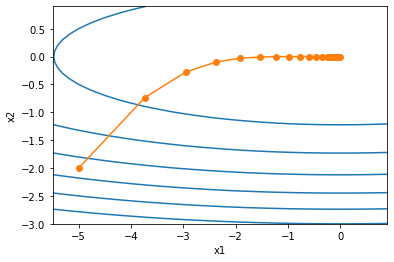

In [2]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

## 7.6.2 从零开始实现

接下来按照RMSProp算法中的公式实现该算法。

In [3]:
features, labels = d2l.get_data_ch7()

def init_rmsprop_states():
    s_w = tf.zeros((features.shape[1],1), dtype=tf.float32)
    s_b = tf.zeros(1, dtype=tf.float32)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams, grads):
    gamma, eps, i = hyperparams['gamma'], 1e-6, 0
    for p,s in zip(params, states):
        s = gamma * s + (1-gamma) * (grads[i])**2
        p.assign_sub(hyperparams['lr']*grads[i]/tf.sqrt(s+eps))
        i+=1

我们将初始学习率设为0.01，并将超参数$\gamma$设为0.9。此时，变量$\boldsymbol{s}_t$可看作是最近$1/(1-0.9) = 10$个时间步的平方项$\boldsymbol{g}_t \odot \boldsymbol{g}_t$的加权平均。

loss: 0.316954, 0.829091 sec per epoch


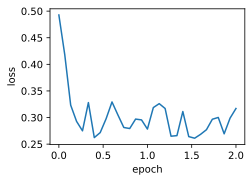

In [4]:
d2l.train_ch7(rmsprop, init_rmsprop_states(), {'lr': 0.01, 'gamma': 0.9},
              features, labels)

## 7.6.3 简洁实现

通过名称为`RMSprop`的优化器方法，我们便可使用Tensorflow2中提供的RMSProp算法来训练模型。注意，超参数$\gamma$通过`alpha`指定。

loss: 0.545120, 1.938334 sec per epoch


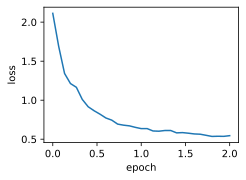

In [6]:
from tensorflow.keras import optimizers
trainer = optimizers.RMSprop(learning_rate=0.01, rho=0.9)
d2l.train_tensorflow2_ch7(trainer, {'lr':0.01}, features, labels)

## 小结

* RMSProp算法和AdaGrad算法的不同在于，**RMSProp算法使用了小批量随机梯度按元素平方的指数加权移动平均来调整学习率**。



## 参考文献

[1] Tieleman, T., & Hinton, G. (2012). Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude. COURSERA: Neural networks for machine learning, 4(2), 26-31.

-----------

> 注：除代码外本节与原书此节基本相同，[原书传送门](https://zh.d2l.ai/chapter_optimization/rmsprop.html)

